In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

torch.Size([1000])


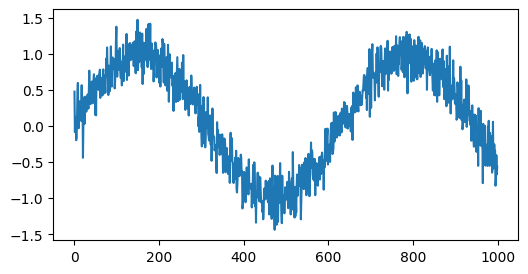

In [3]:
T = 1000
time = torch.arange(0, T, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
print(x.shape)
plt.figure(figsize=(6, 3))
plt.plot(time, x)
plt.show()

In [4]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0275, 0.0197, 0.0374, 0.8186, 0.0968],
         [0.0707, 0.7847, 0.0460, 0.0418, 0.0568]]),
 tensor([1., 1.]))

In [11]:
# 交叉熵损失函数
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# y_hat[[0, 1], y]

def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

print(cross_entropy(y_hat, y))

print(accuracy(y_hat, y) / len(y))
print(y_hat.argmax(axis=0))


tensor([2.3026, 0.6931])
0.5
tensor([1, 0, 0])


In [ ]:
import collections

class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)




In [19]:
import random
import numpy as np

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield np.array(X), np.array(Y)
        
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = np.array(corpus[offset: offset + num_tokens])
    Ys = np.array(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y
                
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


X:  [[17 18 19 20 21]
 [12 13 14 15 16]] 
Y: [[18 19 20 21 22]
 [13 14 15 16 17]]
X:  [[ 7  8  9 10 11]
 [22 23 24 25 26]] 
Y: [[ 8  9 10 11 12]
 [23 24 25 26 27]]
X:  [[ 2  3  4  5  6]
 [27 28 29 30 31]] 
Y: [[ 3  4  5  6  7]
 [28 29 30 31 32]]


In [17]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return np.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = np.random.uniform(0, 1, X.shape) > dropout
    print(mask)
    return mask.astype(np.float32) * X / (1.0 - dropout)

X = np.arange(16).reshape(2, 8)
print(dropout_layer(X, 0.5))

[[False  True  True False False False False False]
 [ True  True False  True False  True False  True]]
[[ 0.  2.  4.  0.  0.  0.  0.  0.]
 [16. 18.  0. 22.  0. 26.  0. 30.]]


*  Nadaraya-Watson核回归
$$ f(x)=\sum_{i=1}^{n} \frac{K\left(x-x_{i}\right)}{\sum_{j=1}^{n} K\left(x-x_{j}\right)} y_{i} $$
* 注意力汇聚（attention pooling）公式：
$$f(x)=\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i}$$
> $\alpha$ : 注意力评分函数
> $x$ : 训练数据真实值
> $x_{i}$ : key值
> $y_{i}$ : value值
* 高斯核
$$ K(u)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{u^{2}}{2}\right)$$ 
* 高斯核代入
$$\begin{aligned}
f(x) & =\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i} \\
& =\sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2}\left(x-x_{i}\right)^{2}\right)}{\sum_{j=1}^{n} \exp \left(-\frac{1}{2}\left(x-x_{j}\right)^{2}\right)} y_{i} \\
& =\sum_{i=1}^{n} \operatorname{softmax}\left(-\frac{1}{2}\left(x-x_{i}\right)^{2}\right) y_{i} .
\end{aligned}$$
* 结论: 如果一越是接近给定的查询， 那么分配给这个键对应值的注意力权重就会越大， 也就“获得了更多的注意力”

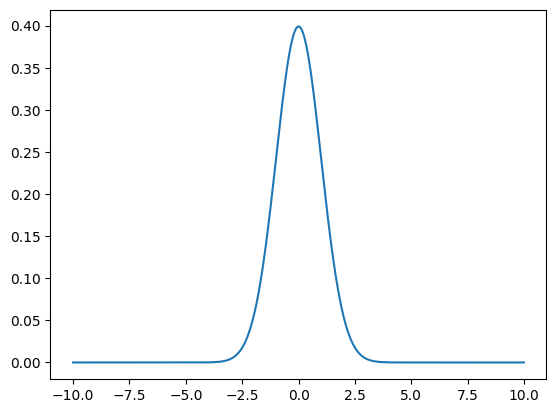

In [8]:
u = torch.arange(-10,10,0.01)
y_gauss = 1/torch.sqrt(2*torch.ones_like(u)*np.pi)*torch.exp(-u**2/2)
plt.plot(u,y_gauss)

>  平均汇聚  和 非参数注意力汇聚

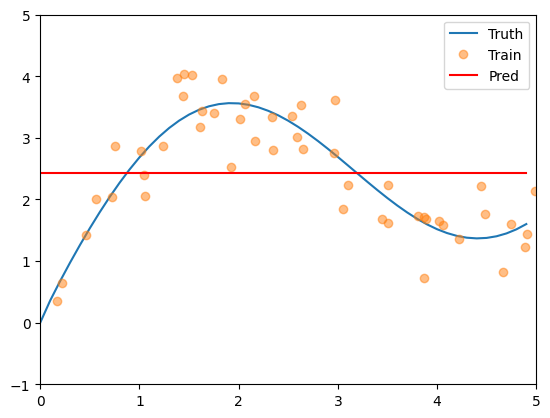

torch.Size([50, 50]) torch.Size([50]) <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([50, 50])


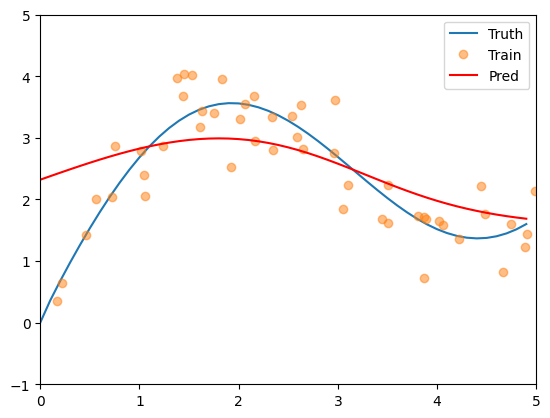

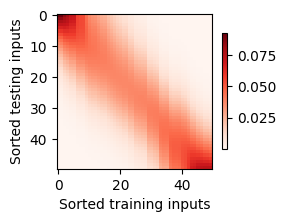

In [2]:
# 生成平均数为0，标准差为1的正态分布
# print(torch.randn(2,3))
# print(torch.normal(0, 1, (2, 3)))

n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test


def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_truth, label='Truth')
    plt.plot(x_train, y_train, 'o', alpha=0.5, label='Train')
    plt.plot(x_test, y_hat, 'r-', label='Pred')
    plt.xlim(0, 5)
    plt.ylim(-1, 5)
    plt.legend()
    plt.show()

#  平均池化, 也就是将所有元素求平均 重复n_test次
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)



# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
print(X_repeat.shape, x_train.shape,type(X_repeat),type(x_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
print(attention_weights.shape)

# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """
        显示热力图
    """
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [10]:
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import SVG, display

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 初始化动画对象
        if legend is None:
            legend = []
        #d2l.use_svg_display()
        display(SVG())
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用列表存储图表对象
        self.config_axes = lambda: self.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """配置图表的坐标轴和图例"""
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        if legend:
            ax.legend(legend)
        ax.grid()    

    def add(self, x, y):
        # 在图表中添加新的数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display(self.fig)
        self.fig.canvas.draw()
        plt.pause(0.001)
        # display.clear_output(wait=True)
        
    def show(self):
        """显示图表"""
        display(self.fig)


> 训练一个简单的网络

<IPython.core.display.SVG object>

epoch 1, loss 44.897804,w 5.487290


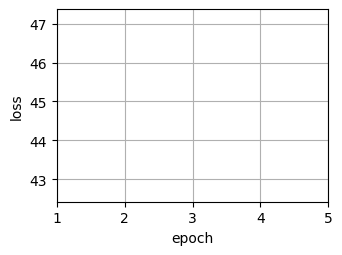

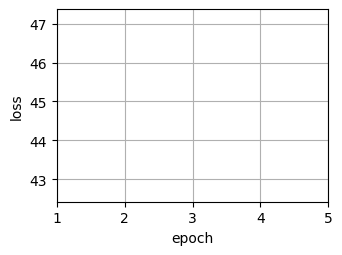

epoch 2, loss 15.518713,w 5.663360


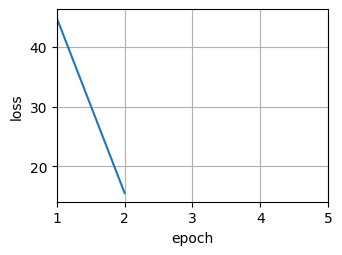

epoch 3, loss 15.462467,w 5.807023


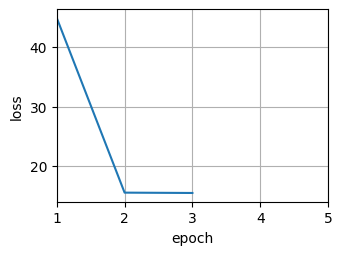

epoch 4, loss 15.424841,w 5.925401


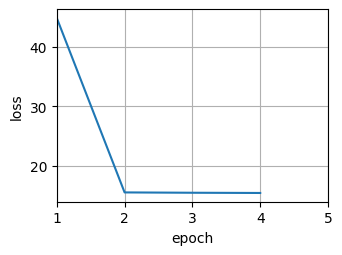

epoch 5, loss 15.399215,w 6.023615


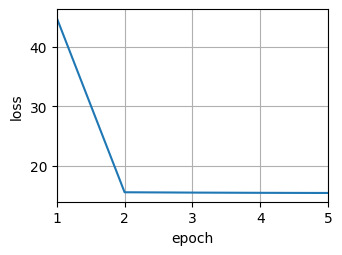

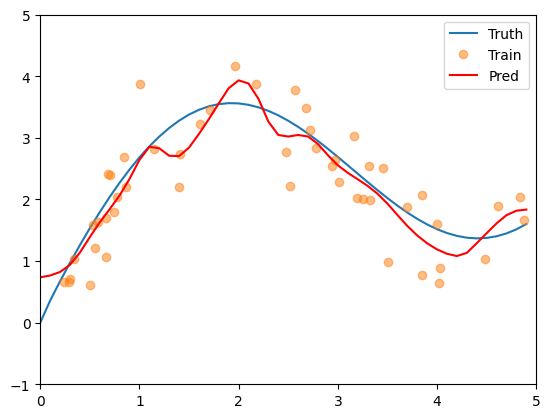

In [15]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 注意力权重的可学习参数
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        """
        :param queries: 查询的张量 ,代表测试数据的特征
        :param keys: 键的张量 , 代表训练数据的特征
        :param values: 值的张量 , 代表训练数据的标签
        """
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数

# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f},w {float(net.w):.6f}')
    animator.add(epoch + 1, float(l.sum()))      
    
    
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)    

* 掩蔽softmax操作

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X: 3D张量，valid_lens: 1D或2D张量
    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = valid_lens.repeat_interleave(shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        mask_value = -1e6
        X_flat = X.reshape(-1, shape[-1])
        mask = torch.arange(X_flat.shape[1])[None, :] >= valid_lens[:, None]
        X_flat[mask] = mask_value
        return F.softmax(X_flat.reshape(shape), dim=-1)
    
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])))

    
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]])))


tensor([[[0.3744, 0.6256, 0.0000, 0.0000],
         [0.4407, 0.5593, 0.0000, 0.0000]],

        [[0.3247, 0.2794, 0.3959, 0.0000],
         [0.4958, 0.2222, 0.2820, 0.0000]]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5357, 0.2283, 0.2360, 0.0000]],

        [[0.4446, 0.5554, 0.0000, 0.0000],
         [0.1785, 0.2202, 0.1725, 0.4288]]])


#### 加性注意力

一般来说, 当查询和键是不同长度的矢量时, 可以使用加性注意力作为评分函数。给定查询  $\mathbf{q} \in \mathbb{R}^{q}$  和 键  $\mathbf{k} \in \mathbb{R}^{k}$ , 加性注意力 (additive attention）的评分函数为

$$a(\mathbf{q}, \mathbf{k})=\mathbf{w}_{v}^{\top} \tanh \left(\mathbf{W}_{q} \mathbf{q}+\mathbf{W}_{k} \mathbf{k}\right) \in \mathbb{R}$$


其中可学习的参数是  $\mathbf{W}_{q} \in \mathbb{R}^{h \times q}$ 、 $\mathbf{W}_{k} \in \mathbb{R}^{h \times k}$  和  $\mathbf{w}_{v} \in \mathbb{R}^{h}$  。如 下图所示, 将查询和键连结起来后输入到一个多层感知机 (MLP) 中, 感知机包含一个隐藏层, 其隐藏单元数是一个超参数  h  。通过使用  \tanh  作为激活函数, 并且禁用偏置项。


In [5]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size,query_size,num_hiddens,dropout,**kwargs):
        super(AdditiveAttention,self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size,num_hiddens,bias=False)
        self.W_q = nn.Linear(query_size,num_hiddens,bias=False)
        self.w_v = nn.Linear(num_hiddens,1,bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,queries,keys,values,valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

使用点积可以得到计算效率更高的评分函数, 但是点积操作要求查询和键具有相同的长度  $d_{\circ}$  假设查询和键的所有元素都是独立的随机变量, 并且都满足零均值和单位方差, 那么两个向量的点积的均值为 0 , 方差为  $d_{\circ}$  为确保无论向量长度如何, 点积的方差在不考虑向量长度的情况下仍然是 1 , 我们再将点积除以  $\sqrt{d}$ , 则缩放点积注意力 (scaled dot-product attention) 评分函数为:

$$(\mathbf{q}, \mathbf{k})=\mathbf{q}^{\top} \mathbf{k} / \sqrt{d}$$


在实践中, 我们通常从小批量的角度来考虑提高效率, 例如基于  n  个查询和  m  个键一值对计算注意力, 其中查询和键的长度为  d , 值的长度为  $v_{\circ}$ 查询  $\mathbf{Q} \in \mathbb{R}^{n \times d}$  、键  $\mathbf{K} \in \mathbb{R}^{m \times d}$  和 值  $\mathbf{V} \in \mathbb{R}^{m \times v}$  的缩放点积注意力是:

$$\operatorname{softmax}\left(\frac{\mathbf{Q} \mathbf{K}^{\top}}{\sqrt{d}}\right) \mathbf{V} \in \mathbb{R}^{n \times v} .$$


下面的缩放点积注意力的实现使用了暂退法进行模型正则化。

In [ ]:
import math

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # transpose 交换维度
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
# complte d2l.Decoder
class D2lDecoder(nn.Module):
    def __init__(self, **kwargs):
        super(D2lDecoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        return enc_outputs

    def forward(self, X, state):
        raise NotImplementedError

    def attention_forward(self, decoder_input, state):
        raise NotImplementedError


class Seq2SeqAttentionDecoder(D2lDecoder):
    """
        :param vocab_size: 词典大小
        :param embed_size: 嵌入层大小
        :param num_hiddens: 隐藏层大小
        :param num_layers: 隐藏层层数
        :param dropout: dropout概率
        
    """
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        # 注意力机制
        self.attention_cell = DotProductAttention(dropout)
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # GRU
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs = []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention_cell(query, enc_outputs, enc_outputs,
                                          enc_valid_lens)
            # 将嵌入后的输入和上下文连接起来
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x的形状改为(num_steps，batch_size，embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
        #  全连接层
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]